## Feature Engineering

 - Covert game date to month only
 - Compile 3, 5, and 7-game rolling means and current win streak for each team as home team and as visitor team as each season progresses
 - Process data in sequential format for each team regardless whether home or away (necessary 1st step for following procedures.)
 - Compile sequential data into head-to-head matchup data for each team pair as each season progress
 - Compile sequential data into 3, 5, 7, and 10-game rolling means and current win streak for each team regardless of home or away as each season progresses
 - Merge sequential data features back into main dataframe
 

In [1]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', 500)

from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from src.common_functions import plot_corr_barchart, plot_corr_vs_target, run_sweetviz_report

from pathlib import Path  #for Windows/Linux compatibility
DATAPATH = Path(r'data')


In [2]:
train = pd.read_csv(DATAPATH / "train.csv")
test = pd.read_csv(DATAPATH / "test.csv")

train

,GAME_DATE_EST,GAME_ID,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,PTS_home,FG_PCT_home,FT_PCT_home,FG3_PCT_home,AST_home,REB_home,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS,PLAYOFF,CONFERENCE_x,G_x,W_x,L_x,W_PCT_x,HOME_W_x,HOME_L_x,HOME_W_PCT_x,ROAD_W_x,ROAD_L_x,ROAD_W_PCT_x,CONFERENCE_y,G_y,W_y,L_y,W_PCT_y,HOME_W_y,HOME_L_y,HOME_W_PCT_y,ROAD_W_y,ROAD_L_y,ROAD_W_PCT_y,TARGET
0,2016-04-25,41500124,1610612766,1610612748,2015,89.0,0.400,0.833,0.250,10.0,36.0,85.0,0.395,0.667,0.379,20.0,46.0,1,1,0,82,48,34,0.585,30,11,0.731707,18,23,0.439024,0,82,48,34,0.585,28,13,0.682927,20,21,0.487805,0.0
1,2016-04-23,41500123,1610612766,1610612748,2015,96.0,0.389,0.955,0.278,18.0,47.0,80.0,0.342,0.633,0.318,13.0,53.0,1,1,0,82,48,34,0.585,30,11,0.731707,18,23,0.439024,0,82,48,34,0.585,28,13,0.682927,20,21,0.487805,1.0
2,2014-04-28,41300114,1610612766,1610612748,2013,98.0,0.507,0.700,0.280,22.0,36.0,109.0,0.500,0.759,0.375,25.0,33.0,0,1,0,82,43,39,0.524,25,16,0.609756,18,23,0.439024,0,82,54,28,0.659,32,9,0.780488,22,19,0.536585,1.0
3,2014-04-26,41300113,1610612766,1610612748,2013,85.0,0.415,0.727,0.389,21.0,38.0,98.0,0.434,0.850,0.500,26.0,39.0,0,1,0,82,43,39,0.524,25,16,0.609756,18,23,0.439024,0,82,54,28,0.659,32,9,0.780488,22,19,0.536585,0.0
4,2010-04-26,40900114,1610612766,1610612753,2009,90.0,0.451,0.636,0.263,27.0,36.0,99.0,0.418,0.714,0.394,18.0,38.0,0,1,0,82,44,38,0.537,31,10,0.756098,13,28,0.317073,0,82,59,23,0.720,34,7,0.829268,25,16,0.609756,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23042,2003-11-22,20300177,1610612737,1610612739,2003,92.0,0.447,0.933,0.200,25.0,45.0,83.0,0.330,0.840,0.571,21.0,54.0,1,0,0,14,5,9,0.357,2,3,0.400000,3,6,0.333333,0,14,4,10,0.286,4,2,0.666667,0,8,0.000000,0.0
23043,2003-11-17,20300141,1610612737,1610612764,2003,97.0,0.423,0.872,0.231,12.0,39.0,106.0,0.390,0.750,0.375,19.0,44.0,0,0,0,11,3,8,0.273,1,3,0.250000,2,5,0.285714,0,10,4,6,0.400,2,3,0.400000,2,3,0.400000,1.0
23044,2003-11-15,20300128,1610612737,1610612751,2003,85.0,0.382,0.767,0.333,19.0,39.0,100.0,0.479,0.867,0.444,23.0,38.0,0,0,0,10,3,7,0.300,1,2,0.333333,2,5,0.285714,0,10,5,5,0.500,2,3,0.400000,3,2,0.600000,0.0
23045,2003-11-03,20300042,1610612737,1610612740,2003,90.0,0.427,0.652,0.333,20.0,50.0,80.0,0.407,0.588,0.222,21.0,42.0,1,0,0,4,1,3,0.250,1,1,0.500000,0,2,0.000000,0,4,3,1,0.750,2,0,1.000000,1,1,0.500000,0.0


In [3]:
def fix_datatypes(df):
    df['GAME_DATE_EST'] = pd.to_datetime(df['GAME_DATE_EST'])

    long_integer_fields = ['GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON']

    #convert long integer fields to int32 from int64
    for field in long_integer_fields:
        df[field] = df[field].astype('int32')
    
    #convert the remaining int64s to int8
    for field in df.select_dtypes(include=['int64']).columns.tolist():
        df[field] = df[field].astype('int8')
        
    #convert float64s to float16s
    for field in df.select_dtypes(include=['float64']).columns.tolist():
        df[field] = df[field].astype('float16')
        
    return df


In [4]:
def add_date_features(df):
    #convert game date to month to limit cardinality

    df['MONTH'] = df['GAME_DATE_EST'].dt.month
    
    return df

In [5]:
def add_past_performance_home_away_by_season(df):

    # add features showing how well the home team has done in its last home games
    # and how well the visitor team has done in its last away games
    # add rolling means for last 3, 5, 7 games
    # add win streaks (negative number if losing streak)
    # these are for the home teams last  *home* games
    # and for the visitor teams last *away* games



    #sort games by the order in which they were played for each home team
    df = df.sort_values(by = ['SEASON', 'HOME_TEAM_ID', 'GAME_ID'], axis=0, ascending=[True, True, True], ignore_index=True)

    # rolling means
    df['HOME_WINPCT_LAST_3_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['HOME_TEAM_WINS'].rolling(3).mean().values
    df['HOME_WINPCT_LAST_5_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['HOME_TEAM_WINS'].rolling(5).mean().values 
    df['HOME_WINPCT_LAST_7_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['HOME_TEAM_WINS'].rolling(7).mean().values

    df['HOME_PTS_AVG_LAST_3_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['PTS_home'].rolling(3).mean().values 
    df['HOME_PTS_AVG_LAST_5_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['PTS_home'].rolling(5).mean().values
    df['HOME_PTS_AVG_LAST_7_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['PTS_home'].rolling(7).mean().values 

    df['HOME_FG_PCT_LAST_3_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['FG_PCT_home'].rolling(3).mean().values 
    df['HOME_FG_PCT_LAST_5_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['FG_PCT_home'].rolling(5).mean().values
    df['HOME_FG_PCT_LAST_7_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['FG_PCT_home'].rolling(7).mean().values 

    df['HOME_FT_PCT_LAST_3_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['FT_PCT_home'].rolling(3).mean().values 
    df['HOME_FT_PCT_LAST_5_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['FT_PCT_home'].rolling(5).mean().values
    df['HOME_FT_PCT_LAST_7_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['FT_PCT_home'].rolling(7).mean().values 

    df['HOME_FG3_PCT_LAST_3_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['FG3_PCT_home'].rolling(3).mean().values 
    df['HOME_FG3_PCT_LAST_5_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['FG3_PCT_home'].rolling(5).mean().values
    df['HOME_FG3_PCT_LAST_7_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['FG3_PCT_home'].rolling(7).mean().values 

    df['HOME_AST_AVG_LAST_3_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['AST_home'].rolling(3).mean().values 
    df['HOME_AST_AVG_LAST_5_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['AST_home'].rolling(5).mean().values
    df['HOME_AST_AVG_LAST_7_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['AST_home'].rolling(7).mean().values 

    df['HOME_REB_AVG_LAST_3_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['REB_home'].rolling(3).mean().values 
    df['HOME_REB_AVG_LAST_5_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['REB_home'].rolling(5).mean().values
    df['HOME_REB_AVG_LAST_7_HOME'] = df.groupby(['SEASON','HOME_TEAM_ID'])['REB_home'].rolling(7).mean().values

    #Home win streak, negative if a losing streak
    df['HOME_TEAM_WIN_STREAK'] = df['HOME_TEAM_WINS'].groupby((df['HOME_TEAM_WINS'] != df.groupby(['SEASON', 'HOME_TEAM_ID'])['HOME_TEAM_WINS'].shift()).cumsum()).cumcount() + 1
    df['HOME_TEAM_WIN_STREAK'].loc[df['HOME_TEAM_WINS'] == 0]  = df['HOME_TEAM_WIN_STREAK'].loc[df['HOME_TEAM_WINS'] == 0]  * -1

    # now for visitor teams        
    df = df.sort_values(by = ['SEASON', 'VISITOR_TEAM_ID', 'GAME_ID'], axis=0, ascending=[True, True, True], ignore_index=True)

    #rolling mean of HOME_TEAM_WINS is the winning pct for home team and *losing* percentage for visitor,
    #to transform: visitor winpct = absolute value of (1 - visitor losing percentage)
    df['VISITOR_WINPCT_LAST_3_AWAY'] = abs(1 - df.groupby(['SEASON','VISITOR_TEAM_ID'])['HOME_TEAM_WINS'].rolling(3).mean().values) 
    df['VISITOR_WINPCT_LAST_5_AWAY'] = abs(1 - df.groupby(['SEASON','VISITOR_TEAM_ID'])['HOME_TEAM_WINS'].rolling(5).mean().values) 
    df['VISITOR_WINPCT_LAST_7_AWAY'] = abs(1 - df.groupby(['SEASON','VISITOR_TEAM_ID'])['HOME_TEAM_WINS'].rolling(7).mean().values) 

    df['VISITOR_PTS_AVG_LAST_3_AWAY'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['PTS_away'].rolling(3).mean().values 
    df['VISITOR_PTS_AVG_LAST_5_AWAY'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['PTS_away'].rolling(5).mean().values 
    df['VISITOR_PTS_AVG_LAST_7_AWAY'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['PTS_away'].rolling(7).mean().values 

    df['VISITOR_FG_PCT_LAST_3_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['FG_PCT_away'].rolling(3).mean().values 
    df['VISITOR_FG_PCT_LAST_5_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['FG_PCT_away'].rolling(5).mean().values
    df['VISITOR_FG_PCT_LAST_7_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['FG_PCT_away'].rolling(7).mean().values 

    df['VISITOR_FT_PCT_LAST_3_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['FT_PCT_away'].rolling(3).mean().values 
    df['VISITOR_FT_PCT_LAST_5_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['FT_PCT_away'].rolling(5).mean().values
    df['VISITOR_FT_PCT_LAST_7_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['FT_PCT_away'].rolling(7).mean().values 

    df['VISITOR_FG3_PCT_LAST_3_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['FG3_PCT_away'].rolling(3).mean().values 
    df['VISITOR_FG3_PCT_LAST_5_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['FG3_PCT_away'].rolling(5).mean().values
    df['VISITOR_FG3_PCT_LAST_7_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['FG3_PCT_away'].rolling(7).mean().values 

    df['VISITOR_AST_AVG_LAST_3_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['AST_away'].rolling(3).mean().values 
    df['VISITOR_AST_AVG_LAST_5_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['AST_away'].rolling(5).mean().values
    df['VISITOR_AST_AVG_LAST_7_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['AST_away'].rolling(7).mean().values 

    df['VISITOR_REB_AVG_LAST_3_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['REB_away'].rolling(3).mean().values 
    df['VISITOR_REB_AVG_LAST_5_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['REB_away'].rolling(5).mean().values
    df['VISITOR_REB_AVG_LAST_7_HOME'] = df.groupby(['SEASON','VISITOR_TEAM_ID'])['REB_away'].rolling(7).mean().values

    #Visitor win streak, negative if a losing streak
    df['VISITOR_TEAM_WIN_STREAK'] = df['HOME_TEAM_WINS'].groupby((df['HOME_TEAM_WINS'] != df.groupby(['SEASON', 'VISITOR_TEAM_ID'])['HOME_TEAM_WINS'].shift()).cumsum()).cumcount() + 1
    df['VISITOR_TEAM_WIN_STREAK'].loc[df['HOME_TEAM_WINS'] == 1]  = df['VISITOR_TEAM_WIN_STREAK'].loc[df['HOME_TEAM_WINS'] == 1]  * -1

    return df



In [6]:
def add_past_performance_home_away(df):

    # new version 2022-10-30
    # now ignoring season boundaries and with longer rolling means (10 and 15 games)
    
    
    # add features showing how well the home team has done in its last home games 
    # and how well the visitor team has done in its last away games
    # add rolling means for last 3, 5, 7, 10, 15 games
    # add win streaks (negative number if losing streak)
    # these are for the home teams last  *home* games
    # and for the visitor teams last *away* games



    #sort games by the order in which they were played for each home team
    df = df.sort_values(by = ['HOME_TEAM_ID', 'GAME_DATE_EST'], axis=0, ascending=[True, True,], ignore_index=True)

    # rolling means
    df['HOME_WINPCT_LAST_3_HOME'] = df.groupby(['HOME_TEAM_ID'])['HOME_TEAM_WINS'].rolling(3).mean().values
    df['HOME_WINPCT_LAST_5_HOME'] = df.groupby(['HOME_TEAM_ID'])['HOME_TEAM_WINS'].rolling(5).mean().values 
    df['HOME_WINPCT_LAST_7_HOME'] = df.groupby(['HOME_TEAM_ID'])['HOME_TEAM_WINS'].rolling(7).mean().values
    df['HOME_WINPCT_LAST_10_HOME'] = df.groupby(['HOME_TEAM_ID'])['HOME_TEAM_WINS'].rolling(10).mean().values
    df['HOME_WINPCT_LAST_15_HOME'] = df.groupby(['HOME_TEAM_ID'])['HOME_TEAM_WINS'].rolling(15).mean().values

    df['HOME_PTS_AVG_LAST_3_HOME'] = df.groupby(['HOME_TEAM_ID'])['PTS_home'].rolling(3).mean().values 
    df['HOME_PTS_AVG_LAST_5_HOME'] = df.groupby(['HOME_TEAM_ID'])['PTS_home'].rolling(5).mean().values
    df['HOME_PTS_AVG_LAST_7_HOME'] = df.groupby(['HOME_TEAM_ID'])['PTS_home'].rolling(7).mean().values 
    df['HOME_PTS_AVG_LAST_10_HOME'] = df.groupby(['HOME_TEAM_ID'])['PTS_home'].rolling(10).mean().values
    df['HOME_PTS_AVG_LAST_15_HOME'] = df.groupby(['HOME_TEAM_ID'])['PTS_home'].rolling(15).mean().values 

    df['HOME_FG_PCT_LAST_3_HOME'] = df.groupby(['HOME_TEAM_ID'])['FG_PCT_home'].rolling(3).mean().values 
    df['HOME_FG_PCT_LAST_5_HOME'] = df.groupby(['HOME_TEAM_ID'])['FG_PCT_home'].rolling(5).mean().values
    df['HOME_FG_PCT_LAST_7_HOME'] = df.groupby(['HOME_TEAM_ID'])['FG_PCT_home'].rolling(7).mean().values 
    df['HOME_FG_PCT_LAST_10_HOME'] = df.groupby(['HOME_TEAM_ID'])['FG_PCT_home'].rolling(10).mean().values
    df['HOME_FG_PCT_LAST_15_HOME'] = df.groupby(['HOME_TEAM_ID'])['FG_PCT_home'].rolling(15).mean().values 

    df['HOME_FT_PCT_LAST_3_HOME'] = df.groupby(['HOME_TEAM_ID'])['FT_PCT_home'].rolling(3).mean().values 
    df['HOME_FT_PCT_LAST_5_HOME'] = df.groupby(['HOME_TEAM_ID'])['FT_PCT_home'].rolling(5).mean().values
    df['HOME_FT_PCT_LAST_7_HOME'] = df.groupby(['HOME_TEAM_ID'])['FT_PCT_home'].rolling(7).mean().values 
    df['HOME_FT_PCT_LAST_10_HOME'] = df.groupby(['HOME_TEAM_ID'])['FT_PCT_home'].rolling(10).mean().values
    df['HOME_FT_PCT_LAST_15_HOME'] = df.groupby(['HOME_TEAM_ID'])['FT_PCT_home'].rolling(15).mean().values 

    df['HOME_FG3_PCT_LAST_3_HOME'] = df.groupby(['HOME_TEAM_ID'])['FG3_PCT_home'].rolling(3).mean().values 
    df['HOME_FG3_PCT_LAST_5_HOME'] = df.groupby(['HOME_TEAM_ID'])['FG3_PCT_home'].rolling(5).mean().values
    df['HOME_FG3_PCT_LAST_7_HOME'] = df.groupby(['HOME_TEAM_ID'])['FG3_PCT_home'].rolling(7).mean().values 
    df['HOME_FG3_PCT_LAST_10_HOME'] = df.groupby(['HOME_TEAM_ID'])['FG3_PCT_home'].rolling(10).mean().values
    df['HOME_FG3_PCT_LAST_15_HOME'] = df.groupby(['HOME_TEAM_ID'])['FG3_PCT_home'].rolling(15).mean().values 

    df['HOME_AST_AVG_LAST_3_HOME'] = df.groupby(['HOME_TEAM_ID'])['AST_home'].rolling(3).mean().values 
    df['HOME_AST_AVG_LAST_5_HOME'] = df.groupby(['HOME_TEAM_ID'])['AST_home'].rolling(5).mean().values
    df['HOME_AST_AVG_LAST_7_HOME'] = df.groupby(['HOME_TEAM_ID'])['AST_home'].rolling(7).mean().values
    df['HOME_AST_AVG_LAST_10_HOME'] = df.groupby(['HOME_TEAM_ID'])['AST_home'].rolling(10).mean().values
    df['HOME_AST_AVG_LAST_15_HOME'] = df.groupby(['HOME_TEAM_ID'])['AST_home'].rolling(15).mean().values 

    df['HOME_REB_AVG_LAST_3_HOME'] = df.groupby(['HOME_TEAM_ID'])['REB_home'].rolling(3).mean().values 
    df['HOME_REB_AVG_LAST_5_HOME'] = df.groupby(['HOME_TEAM_ID'])['REB_home'].rolling(5).mean().values
    df['HOME_REB_AVG_LAST_7_HOME'] = df.groupby(['HOME_TEAM_ID'])['REB_home'].rolling(7).mean().values
    df['HOME_REB_AVG_LAST_10_HOME'] = df.groupby(['HOME_TEAM_ID'])['REB_home'].rolling(10).mean().values
    df['HOME_REB_AVG_LAST_15_HOME'] = df.groupby(['HOME_TEAM_ID'])['REB_home'].rolling(15).mean().values

    #Home win streak, negative if a losing streak
    df['HOME_TEAM_WIN_STREAK'] = df['HOME_TEAM_WINS'].groupby((df['HOME_TEAM_WINS'] != df.groupby(['HOME_TEAM_ID'])['HOME_TEAM_WINS'].shift()).cumsum()).cumcount() + 1
    df['HOME_TEAM_WIN_STREAK'].loc[df['HOME_TEAM_WINS'] == 0]  = df['HOME_TEAM_WIN_STREAK'].loc[df['HOME_TEAM_WINS'] == 0]  * -1

    # now for visitor teams        
    df = df.sort_values(by = ['VISITOR_TEAM_ID', 'GAME_DATE_EST'], axis=0, ascending=[True, True], ignore_index=True)

    #rolling mean of HOME_TEAM_WINS is the winning pct for home team and *losing* percentage for visitor,
    #to transform: visitor winpct = absolute value of (1 - visitor losing percentage)
    df['VISITOR_WINPCT_LAST_3_AWAY'] = abs(1 - df.groupby(['VISITOR_TEAM_ID'])['HOME_TEAM_WINS'].rolling(3).mean().values) 
    df['VISITOR_WINPCT_LAST_5_AWAY'] = abs(1 - df.groupby(['VISITOR_TEAM_ID'])['HOME_TEAM_WINS'].rolling(5).mean().values) 
    df['VISITOR_WINPCT_LAST_7_AWAY'] = abs(1 - df.groupby(['VISITOR_TEAM_ID'])['HOME_TEAM_WINS'].rolling(7).mean().values) 
    df['VISITOR_WINPCT_LAST_10_AWAY'] = abs(1 - df.groupby(['VISITOR_TEAM_ID'])['HOME_TEAM_WINS'].rolling(10).mean().values) 
    df['VISITOR_WINPCT_LAST_15_AWAY'] = abs(1 - df.groupby(['VISITOR_TEAM_ID'])['HOME_TEAM_WINS'].rolling(15).mean().values) 

    df['VISITOR_PTS_AVG_LAST_3_AWAY'] = df.groupby(['VISITOR_TEAM_ID'])['PTS_away'].rolling(3).mean().values 
    df['VISITOR_PTS_AVG_LAST_5_AWAY'] = df.groupby(['VISITOR_TEAM_ID'])['PTS_away'].rolling(5).mean().values 
    df['VISITOR_PTS_AVG_LAST_7_AWAY'] = df.groupby(['VISITOR_TEAM_ID'])['PTS_away'].rolling(7).mean().values 
    df['VISITOR_PTS_AVG_LAST_10_AWAY'] = df.groupby(['VISITOR_TEAM_ID'])['PTS_away'].rolling(10).mean().values 
    df['VISITOR_PTS_AVG_LAST_15_AWAY'] = df.groupby(['VISITOR_TEAM_ID'])['PTS_away'].rolling(15).mean().values 

    df['VISITOR_FG_PCT_LAST_3_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG_PCT_away'].rolling(3).mean().values 
    df['VISITOR_FG_PCT_LAST_5_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG_PCT_away'].rolling(5).mean().values
    df['VISITOR_FG_PCT_LAST_7_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG_PCT_away'].rolling(7).mean().values 
    df['VISITOR_FG_PCT_LAST_10_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG_PCT_away'].rolling(10).mean().values
    df['VISITOR_FG_PCT_LAST_15_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG_PCT_away'].rolling(15).mean().values 

    df['VISITOR_FT_PCT_LAST_3_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FT_PCT_away'].rolling(3).mean().values 
    df['VISITOR_FT_PCT_LAST_5_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FT_PCT_away'].rolling(5).mean().values
    df['VISITOR_FT_PCT_LAST_7_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FT_PCT_away'].rolling(7).mean().values 
    df['VISITOR_FT_PCT_LAST_10_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FT_PCT_away'].rolling(10).mean().values
    df['VISITOR_FT_PCT_LAST_15_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FT_PCT_away'].rolling(15).mean().values 

    df['VISITOR_FG3_PCT_LAST_3_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG3_PCT_away'].rolling(3).mean().values 
    df['VISITOR_FG3_PCT_LAST_5_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG3_PCT_away'].rolling(5).mean().values
    df['VISITOR_FG3_PCT_LAST_7_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG3_PCT_away'].rolling(7).mean().values 
    df['VISITOR_FG3_PCT_LAST_10_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG3_PCT_away'].rolling(10).mean().values
    df['VISITOR_FG3_PCT_LAST_15_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG3_PCT_away'].rolling(15).mean().values 

    df['VISITOR_AST_AVG_LAST_3_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['AST_away'].rolling(3).mean().values 
    df['VISITOR_AST_AVG_LAST_5_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['AST_away'].rolling(5).mean().values
    df['VISITOR_AST_AVG_LAST_7_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['AST_away'].rolling(7).mean().values 
    df['VISITOR_AST_AVG_LAST_10_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['AST_away'].rolling(10).mean().values
    df['VISITOR_AST_AVG_LAST_15_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['AST_away'].rolling(15).mean().values 

    df['VISITOR_REB_AVG_LAST_3_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['REB_away'].rolling(3).mean().values 
    df['VISITOR_REB_AVG_LAST_5_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['REB_away'].rolling(5).mean().values
    df['VISITOR_REB_AVG_LAST_7_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['REB_away'].rolling(7).mean().values
    df['VISITOR_REB_AVG_LAST_10_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['REB_away'].rolling(10).mean().values
    df['VISITOR_REB_AVG_LAST_15_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['REB_away'].rolling(15).mean().values

    #Visitor win streak, negative if a losing streak
    df['VISITOR_TEAM_WIN_STREAK'] = df['HOME_TEAM_WINS'].groupby((df['HOME_TEAM_WINS'] != df.groupby(['VISITOR_TEAM_ID'])['HOME_TEAM_WINS'].shift()).cumsum()).cumcount() + 1
    df['VISITOR_TEAM_WIN_STREAK'].loc[df['HOME_TEAM_WINS'] == 1]  = df['VISITOR_TEAM_WIN_STREAK'].loc[df['HOME_TEAM_WINS'] == 1]  * -1

    return df



In [7]:
def process_games_consecutively(df_data):
    # re-organize so that all of a team's games can be listed in chronological order whether HOME or VISITOR
    # this will facilitate feature engineering (winpct vs team X, 5-game winpct, current win streak, etc...)
    
    #this data will need to be re-linked back to the main dataframe after all processing is done,
    #joining TEAM1 to HOME_TEAM_ID for all records and then TEAM1 to VISITOR_TEAM_ID for all records
    
    #TEAM1 will be the key field. TEAM2 is used solely to process past team matchups

    # all the home games for each team will be selected and then stacked with all the away games
    
    df_home = pd.DataFrame()
    df_home['GAME_DATE_EST'] = df_data['GAME_DATE_EST']
    df_home['GAME_ID'] = df_data['GAME_ID']
    df_home['TEAM1'] = df_data['HOME_TEAM_ID']
    df_home['TEAM1_home'] = 1
    df_home['TEAM1_win'] = df_data['HOME_TEAM_WINS']
    df_home['TEAM2'] = df_data['VISITOR_TEAM_ID']
    df_home['SEASON'] = df_data['SEASON']
    
    df_home['PTS'] = df_data['PTS_home']
    df_home['FG_PCT'] = df_data['FG_PCT_home']
    df_home['FT_PCT'] = df_data['FT_PCT_home']
    df_home['FG3_PCT'] = df_data['FG3_PCT_home']
    df_home['AST'] = df_data['AST_home']
    df_home['REB'] = df_data['REB_home']
    
    # now for visitor teams  

    df_visitor = pd.DataFrame()
    df_visitor['GAME_DATE_EST'] = df_data['GAME_DATE_EST']
    df_visitor['GAME_ID'] = df_data['GAME_ID']
    df_visitor['TEAM1'] = df_data['VISITOR_TEAM_ID'] 
    df_visitor['TEAM1_home'] = 0
    df_visitor['TEAM1_win'] = df_data['HOME_TEAM_WINS'].apply(lambda x: 1 if x == 0 else 0)
    df_visitor['TEAM2'] = df_data['HOME_TEAM_ID']
    df_visitor['SEASON'] = df_data['SEASON']
    
    df_visitor['PTS'] = df_data['PTS_away']
    df_visitor['FG_PCT'] = df_data['FG_PCT_away']
    df_visitor['FT_PCT'] = df_data['FT_PCT_away']
    df_visitor['FG3_PCT'] = df_data['FG3_PCT_away']
    df_visitor['AST'] = df_data['AST_away']
    df_visitor['REB'] = df_data['REB_away']

    # merge dfs

    df = pd.concat([df_home, df_visitor])

    column2 = df.pop('TEAM1')
    column3 = df.pop('TEAM1_home')
    column4 = df.pop('TEAM2')
    column5 = df.pop('TEAM1_win')

    df.insert(2,'TEAM1', column2)
    df.insert(3,'TEAM1_home', column3)
    df.insert(4,'TEAM2', column4)
    df.insert(5,'TEAM1_win', column5)

    df = df.sort_values(by = ['TEAM1', 'GAME_ID'], axis=0, ascending=[True, True], ignore_index=True)

    return df


In [8]:
def add_matchups_by_season(df):

    # group all the games that 2 teams played each other for a season
    # calculate the expanding values for wins, games played, and win percentage as the season progressed
    

    df = df.sort_values(by = ['SEASON','TEAM1', 'TEAM2','GAME_ID'], axis=0, ascending=[True,True, True, True], ignore_index=True)

    df['MATCHUP_WINS'] = df.groupby(['SEASON','TEAM1','TEAM2'])['TEAM1_win'].expanding(1).mean().values
    df['MATCHUP_COUNT'] = df.groupby(['SEASON','TEAM1','TEAM2'])['TEAM1_win'].expanding(1).count().values
    df['MATCHUP_WINPCT'] = df['MATCHUP_WINS'] / df['MATCHUP_COUNT']
    df['MATCHUP_WIN_STREAK'] = df['TEAM1_win'].groupby((df['TEAM1_win'] != df.groupby(['SEASON','TEAM1','TEAM2'])['TEAM1_win'].shift()).cumsum()).cumcount() + 1
    #make streak negative if a losing streak
    df['MATCHUP_WIN_STREAK'].loc[df['TEAM1_win'] == 0]  = df['MATCHUP_WIN_STREAK'].loc[df['TEAM1_win'] == 0]  * -1

    
    return df



In [9]:
def add_matchups(df):

    # new version 2022-10-30
    # now ignoring season boundaries

    # group all the games that 2 teams played each other 
    # calculate the expanding values for wins, games played, and win percentage
    

    df = df.sort_values(by = ['TEAM1', 'TEAM2','GAME_DATE_EST'], axis=0, ascending=[True, True, True], ignore_index=True)

    df['MATCHUP_WINS'] = df.groupby(['TEAM1','TEAM2'])['TEAM1_win'].expanding(1).mean().values
    df['MATCHUP_COUNT'] = df.groupby(['TEAM1','TEAM2'])['TEAM1_win'].expanding(1).count().values
    df['MATCHUP_WINPCT'] = df['MATCHUP_WINS'] / df['MATCHUP_COUNT']
    df['MATCHUP_WIN_STREAK'] = df['TEAM1_win'].groupby((df['TEAM1_win'] != df.groupby(['TEAM1','TEAM2'])['TEAM1_win'].shift()).cumsum()).cumcount() + 1
    #make streak negative if a losing streak
    df['MATCHUP_WIN_STREAK'].loc[df['TEAM1_win'] == 0]  = df['MATCHUP_WIN_STREAK'].loc[df['TEAM1_win'] == 0]  * -1

    
    return df



In [10]:
def add_past_performance_all_by_season(df):
   
    # add features showing how well each team has done in its last games
    # regardless whether they were at home or away
    # add rolling means for last 3, 5, 7, 10 games
    # add win streaks (negative number if losing streak)
    
    #this data will need to be re-linked back to the main dataframe after all processing is done,
    #joining TEAM1 to HOME_TEAM_ID for all records and then TEAM1 to VISITOR_TEAM_ID for all records
    
    #TEAM1 will be the key field. TEAM2 was used solely to process past team matchups


    df = df.sort_values(by = ['SEASON','TEAM1','GAME_ID'], axis=0, ascending=[True,True, True,], ignore_index=True)
  
    #streak of games won/lost, make negative is a losing streak
    df['WIN_STREAK'] = df['TEAM1_win'].groupby((df['TEAM1_win'] != df.groupby(['SEASON','TEAM1'])['TEAM1_win'].shift()).cumsum()).cumcount() + 1
    df['WIN_STREAK'].loc[df['TEAM1_win'] == 0]  = df['WIN_STREAK'].loc[df['TEAM1_win'] == 0]  * -1
    
    #streak of games played at home/away, make negative if away streak
    df['HOME_AWAY_STREAK'] = df['TEAM1_home'].groupby((df['TEAM1_home'] != df.groupby(['SEASON','TEAM1'])['TEAM1_home'].shift()).cumsum()).cumcount() + 1
    df['HOME_AWAY_STREAK'].loc[df['TEAM1_home'] == 0]  = df['HOME_AWAY_STREAK'].loc[df['TEAM1_home'] == 0]  * -1
    
    #rolling means for last 3, 5 ,7, 10 games
    df['WINPCT_LAST_3_ALL'] = df.groupby(['SEASON','TEAM1'])['TEAM1_win'].rolling(3).mean().values 
    df['WINPCT_LAST_5_ALL'] = df.groupby(['SEASON','TEAM1'])['TEAM1_win'].rolling(5).mean().values 
    df['WINPCT_LAST_7_ALL'] = df.groupby(['SEASON','TEAM1'])['TEAM1_win'].rolling(7).mean().values 
    df['WINPCT_LAST_10_ALL'] = df.groupby(['SEASON','TEAM1'])['TEAM1_win'].rolling(10).mean().values 

    df['PTS_AVG_LAST_3_ALL'] = df.groupby(['SEASON','TEAM1'])['PTS'].rolling(3).mean().values
    df['PTS_AVG_LAST_5_ALL'] = df.groupby(['SEASON','TEAM1'])['PTS'].rolling(5).mean().values
    df['PTS_AVG_LAST_7_ALL'] = df.groupby(['SEASON','TEAM1'])['PTS'].rolling(7).mean().values
    df['PTS_AVG_LAST_10_ALL'] = df.groupby(['SEASON','TEAM1'])['PTS'].rolling(10).mean().values
    
    df['FG_PCT_LAST_3_ALL'] = df.groupby(['SEASON','TEAM1'])['FG_PCT'].rolling(3).mean().values
    df['FG_PCT_LAST_5_ALL'] = df.groupby(['SEASON','TEAM1'])['FG_PCT'].rolling(5).mean().values
    df['FG_PCT_LAST_7_ALL'] = df.groupby(['SEASON','TEAM1'])['FG_PCT'].rolling(7).mean().values
    df['FG_PCT_LAST_10_ALL'] = df.groupby(['SEASON','TEAM1'])['FG_PCT'].rolling(10).mean().values
    
    df['FT_PCT_LAST_3_ALL'] = df.groupby(['SEASON','TEAM1'])['FT_PCT'].rolling(3).mean().values
    df['FT_PCT_LAST_5_ALL'] = df.groupby(['SEASON','TEAM1'])['FT_PCT'].rolling(5).mean().values
    df['FT_PCT_LAST_7_ALL'] = df.groupby(['SEASON','TEAM1'])['FT_PCT'].rolling(7).mean().values
    df['FT_PCT_LAST_10_ALL'] = df.groupby(['SEASON','TEAM1'])['FT_PCT'].rolling(10).mean().values

    df['AST_AVG_LAST_3_ALL'] = df.groupby(['SEASON','TEAM1'])['AST'].rolling(3).mean().values
    df['AST_AVG_LAST_5_ALL'] = df.groupby(['SEASON','TEAM1'])['AST'].rolling(5).mean().values
    df['AST_AVG_LAST_7_ALL'] = df.groupby(['SEASON','TEAM1'])['AST'].rolling(7).mean().values
    df['AST_AVG_LAST_10_ALL'] = df.groupby(['SEASON','TEAM1'])['AST'].rolling(10).mean().values
    
    df['REB_AVG_LAST_3_ALL'] = df.groupby(['SEASON','TEAM1'])['REB'].rolling(3).mean().values
    df['REB_AVG_LAST_5_ALL'] = df.groupby(['SEASON','TEAM1'])['REB'].rolling(5).mean().values
    df['REB_AVG_LAST_7_ALL'] = df.groupby(['SEASON','TEAM1'])['REB'].rolling(7).mean().values
    df['REB_AVG_LAST_10_ALL'] = df.groupby(['SEASON','TEAM1'])['REB'].rolling(10).mean().values
    
    return df



In [11]:
def add_past_performance_all(df):
    
    # new version 2022-10-30
    # now ignoring season boundaries and with longer rolling means (20 and 40 games)
   
    # add features showing how well each team has done in its last games
    # regardless whether they were at home or away
    # add rolling means for last 3, 5, 7, 10, 20, 40 games
    # add win streaks (negative number if losing streak)
    
    #this data will need to be re-linked back to the main dataframe after all processing is done,
    #joining TEAM1 to HOME_TEAM_ID for all records and then TEAM1 to VISITOR_TEAM_ID for all records
    
    #TEAM1 will be the key field. TEAM2 was used solely to process past team matchups


    df = df.sort_values(by = ['TEAM1','GAME_ID'], axis=0, ascending=[True, True,], ignore_index=True)
  
    #streak of games won/lost, make negative is a losing streak
    df['WIN_STREAK'] = df['TEAM1_win'].groupby((df['TEAM1_win'] != df.groupby(['TEAM1'])['TEAM1_win'].shift()).cumsum()).cumcount() + 1
    df['WIN_STREAK'].loc[df['TEAM1_win'] == 0]  = df['WIN_STREAK'].loc[df['TEAM1_win'] == 0]  * -1
    
    #streak of games played at home/away, make negative if away streak
    df['HOME_AWAY_STREAK'] = df['TEAM1_home'].groupby((df['TEAM1_home'] != df.groupby(['TEAM1'])['TEAM1_home'].shift()).cumsum()).cumcount() + 1
    df['HOME_AWAY_STREAK'].loc[df['TEAM1_home'] == 0]  = df['HOME_AWAY_STREAK'].loc[df['TEAM1_home'] == 0]  * -1
    
    #rolling means for last 3, 5 ,7, 10 games
    df['WINPCT_LAST_3_ALL'] = df.groupby(['TEAM1'])['TEAM1_win'].rolling(3).mean().values 
    df['WINPCT_LAST_5_ALL'] = df.groupby(['TEAM1'])['TEAM1_win'].rolling(5).mean().values 
    df['WINPCT_LAST_7_ALL'] = df.groupby(['TEAM1'])['TEAM1_win'].rolling(7).mean().values 
    df['WINPCT_LAST_10_ALL'] = df.groupby(['TEAM1'])['TEAM1_win'].rolling(10).mean().values 
    df['WINPCT_LAST_20_ALL'] = df.groupby(['TEAM1'])['TEAM1_win'].rolling(20).mean().values 
    df['WINPCT_LAST_40_ALL'] = df.groupby(['TEAM1'])['TEAM1_win'].rolling(40).mean().values 

    df['PTS_AVG_LAST_3_ALL'] = df.groupby(['TEAM1'])['PTS'].rolling(3).mean().values
    df['PTS_AVG_LAST_5_ALL'] = df.groupby(['TEAM1'])['PTS'].rolling(5).mean().values
    df['PTS_AVG_LAST_7_ALL'] = df.groupby(['TEAM1'])['PTS'].rolling(7).mean().values
    df['PTS_AVG_LAST_10_ALL'] = df.groupby(['TEAM1'])['PTS'].rolling(10).mean().values
    df['PTS_AVG_LAST_20_ALL'] = df.groupby(['TEAM1'])['PTS'].rolling(20).mean().values
    df['PTS_AVG_LAST_40_ALL'] = df.groupby(['TEAM1'])['PTS'].rolling(40).mean().values
    
    df['FG_PCT_LAST_3_ALL'] = df.groupby(['TEAM1'])['FG_PCT'].rolling(3).mean().values
    df['FG_PCT_LAST_5_ALL'] = df.groupby(['TEAM1'])['FG_PCT'].rolling(5).mean().values
    df['FG_PCT_LAST_7_ALL'] = df.groupby(['TEAM1'])['FG_PCT'].rolling(7).mean().values
    df['FG_PCT_LAST_10_ALL'] = df.groupby(['TEAM1'])['FG_PCT'].rolling(10).mean().values
    df['FG_PCT_LAST_20_ALL'] = df.groupby(['TEAM1'])['FG_PCT'].rolling(20).mean().values
    df['FG_PCT_LAST_40_ALL'] = df.groupby(['TEAM1'])['FG_PCT'].rolling(40).mean().values
    
    df['FT_PCT_LAST_3_ALL'] = df.groupby(['TEAM1'])['FT_PCT'].rolling(3).mean().values
    df['FT_PCT_LAST_5_ALL'] = df.groupby(['TEAM1'])['FT_PCT'].rolling(5).mean().values
    df['FT_PCT_LAST_7_ALL'] = df.groupby(['TEAM1'])['FT_PCT'].rolling(7).mean().values
    df['FT_PCT_LAST_10_ALL'] = df.groupby(['TEAM1'])['FT_PCT'].rolling(10).mean().values
    df['FT_PCT_LAST_20_ALL'] = df.groupby(['TEAM1'])['FT_PCT'].rolling(20).mean().values
    df['FT_PCT_LAST_40_ALL'] = df.groupby(['TEAM1'])['FT_PCT'].rolling(40).mean().values

    df['AST_AVG_LAST_3_ALL'] = df.groupby(['TEAM1'])['AST'].rolling(3).mean().values
    df['AST_AVG_LAST_5_ALL'] = df.groupby(['TEAM1'])['AST'].rolling(5).mean().values
    df['AST_AVG_LAST_7_ALL'] = df.groupby(['TEAM1'])['AST'].rolling(7).mean().values
    df['AST_AVG_LAST_10_ALL'] = df.groupby(['TEAM1'])['AST'].rolling(10).mean().values
    df['AST_AVG_LAST_20_ALL'] = df.groupby(['TEAM1'])['AST'].rolling(20).mean().values
    df['AST_AVG_LAST_40_ALL'] = df.groupby(['TEAM1'])['AST'].rolling(40).mean().values
    
    df['REB_AVG_LAST_3_ALL'] = df.groupby(['TEAM1'])['REB'].rolling(3).mean().values
    df['REB_AVG_LAST_5_ALL'] = df.groupby(['TEAM1'])['REB'].rolling(5).mean().values
    df['REB_AVG_LAST_7_ALL'] = df.groupby(['TEAM1'])['REB'].rolling(7).mean().values
    df['REB_AVG_LAST_10_ALL'] = df.groupby(['TEAM1'])['REB'].rolling(10).mean().values
    df['REB_AVG_LAST_20_ALL'] = df.groupby(['TEAM1'])['REB'].rolling(20).mean().values
    df['REB_AVG_LAST_40_ALL'] = df.groupby(['TEAM1'])['REB'].rolling(40).mean().values
    
    
    return df



In [12]:
def combine_new_features(df, df_consecutive):
     
    # add back all the new features created in the consecutive dataframe to the main dataframe
    # all data for TEAM1 will be applied to the home team and then again to the visitor team
    # except for head-to-head MATCHUP data, which will only be applied to home team (redundant to include for both)
    # the letter '_x' will be appeneded to feature names when adding to home team
    # the letter '_y' will be appended to feature names when adding to visitor team
    # to match the existing convention in the dataset
    
    #first select out the new features
    all_features = df_consecutive.columns.tolist()
    link_features = ['GAME_ID', 'TEAM1', ]
    redundant_features = ['GAME_DATE_EST','TEAM1_home','TEAM1_win','TEAM2','SEASON','PTS', 'FG_PCT', 'FT_PCT', 'FG3_PCT', 'AST', 'REB',]
    matchup_features = ['MATCHUP_WINS', 'MATCHUP_COUNT', 'MATCHUP_WINPCT', 'MATCHUP_WIN_STREAK']
    ignore_features = link_features + redundant_features
    
    new_features = [x for x in all_features if x not in ignore_features]
    
    # first home teams
    
    df1 = df_consecutive[df_consecutive['TEAM1_home'] == 1]
    #add "_x" to new features
    df1.columns = [x + '_x' if x in new_features else x for x in df1.columns]
    #drop features that don't need to be merged
    df1 = df1.drop(redundant_features,axis=1)
    #change TEAM1 to HOME_TEAM_ID for easy merging
    df1 = df1.rename(columns={'TEAM1': 'HOME_TEAM_ID'})
    df = pd.merge(df, df1, how="left", on=["GAME_ID", "HOME_TEAM_ID"])
    
    #don't include matchup features for visitor team since they are equivant for both home and visitor
    new_features = [x for x in new_features if x not in matchup_features]
    df_consecutive = df_consecutive.drop(matchup_features,axis=1)
    
    # next visitor teams
    
    df2 = df_consecutive[df_consecutive['TEAM1_home'] == 0]
    #add "_y" to new features
    df2.columns = [x + '_y' if x in new_features else x for x in df2.columns]
    #drop features that don't need to be merged
    df2 = df2.drop(redundant_features,axis=1)
    #change TEAM1 to VISITOR_TEAM_ID for easy merging
    df2 = df2.rename(columns={'TEAM1': 'VISITOR_TEAM_ID'})
    df = pd.merge(df, df2, how="left", on=["GAME_ID", "VISITOR_TEAM_ID"])
    
    return df

In [13]:
def add_all_features(df):
    
    df = fix_datatypes(df)
    df = add_date_features(df)
    df = add_past_performance_home_away(df)

    #games must first be processed to sort all games in order per team
    #regardless whether home or away
    df_consecutive = process_games_consecutively(df)
    df_consecutive = add_matchups(df_consecutive)
    df_consecutive = add_past_performance_all(df_consecutive)

    #add these features back to main dataframe
    df = combine_new_features(df,df_consecutive) 
    
    return df

### Add Features

In [14]:
train_features = add_all_features(train)
test_features = add_all_features(test)

C:\Users\Chris\AppData\Local\Temp\ipykernel_13280\2217858559.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['HOME_TEAM_WIN_STREAK'].loc[df['HOME_TEAM_WINS'] == 0]  = df['HOME_TEAM_WIN_STREAK'].loc[df['HOME_TEAM_WINS'] == 0]  * -1
C:\Users\Chris\AppData\Local\Temp\ipykernel_13280\2217858559.py:96: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['VISITOR_FG3_PCT_LAST_5_HOME'] = df.groupby(['VISITOR_TEAM_ID'])['FG3_PCT_away'].rolling(5).mean().values
C:\Users\Chris\AppData\Local\Temp\ipykernel_13280\2217858559.py:97: PerformanceWarning: DataFrame is highly fragmented

### Save data

In [15]:
train_features.to_csv(DATAPATH / "train_features.csv",index=False)
test_features.to_csv(DATAPATH / "test_features.csv",index=False)

### Visualization

G_x                           G_y                             0.998290
W_x                           HOME_W_x                        0.981039
W_y                           HOME_W_y                        0.980752
L_y                           ROAD_L_y                        0.973920
L_x                           ROAD_L_x                        0.973444
W_x                           ROAD_W_x                        0.963648
W_y                           ROAD_W_y                        0.961943
HOME_PTS_AVG_LAST_10_HOME     HOME_PTS_AVG_LAST_15_HOME       0.952340
PTS_AVG_LAST_7_ALL_x          PTS_AVG_LAST_10_ALL_x           0.950326
L_y                           HOME_L_y                        0.950266
VISITOR_PTS_AVG_LAST_10_AWAY  VISITOR_PTS_AVG_LAST_15_AWAY    0.950160
PTS_AVG_LAST_7_ALL_y          PTS_AVG_LAST_10_ALL_y           0.950089
HOME_PTS_AVG_LAST_7_HOME      HOME_PTS_AVG_LAST_10_HOME       0.949950
L_x                           HOME_L_x                        0.947876
VISITO

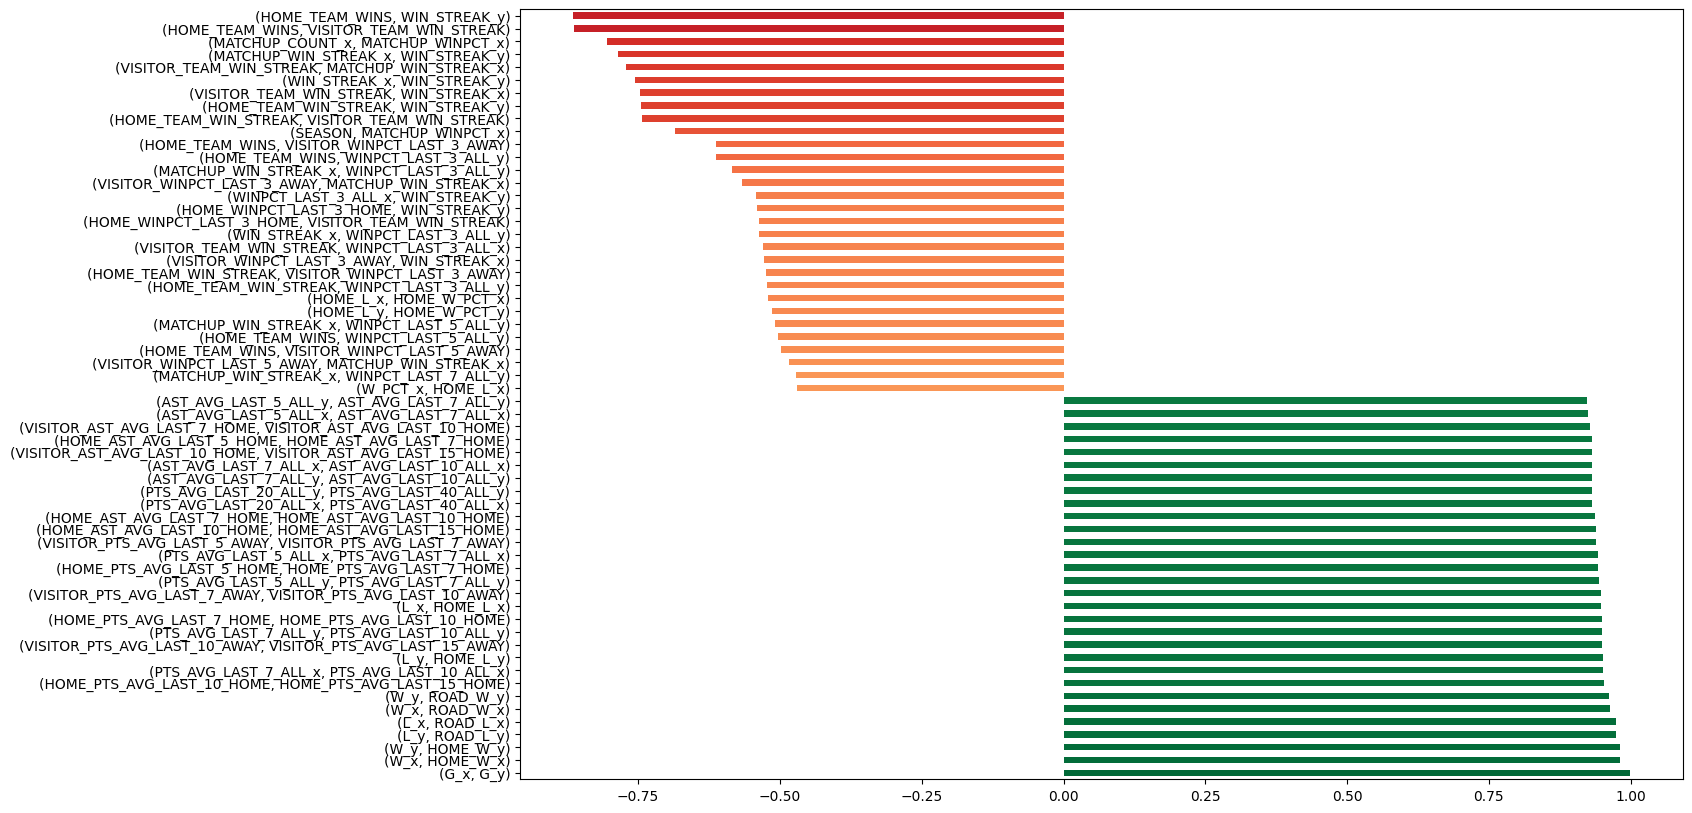

In [16]:
# correlation bar chart
  
drop_cols = ['GAME_ID']
n = 30

plot_corr_barchart(train_features,drop_cols,n)

WINPCT_LAST_40_ALL_x            0.207890
WINPCT_LAST_20_ALL_x            0.205348
HOME_TEAM_WINS                  0.202593
W_PCT_x                         0.199752
HOME_WINPCT_LAST_15_HOME        0.197246
WINPCT_LAST_10_ALL_x            0.190829
HOME_WINPCT_LAST_10_HOME        0.186877
HOME_W_PCT_x                    0.185469
HOME_WINPCT_LAST_7_HOME         0.181177
WINPCT_LAST_7_ALL_x             0.170883
ROAD_W_PCT_x                    0.170482
WINPCT_LAST_5_ALL_x             0.164586
HOME_WINPCT_LAST_5_HOME         0.163688
HOME_WINPCT_LAST_3_HOME         0.158032
WINPCT_LAST_3_ALL_x             0.152411
PLAYOFF                         0.149746
HOME_TEAM_WIN_STREAK            0.134809
WIN_STREAK_x                    0.134738
MATCHUP_WIN_STREAK_x            0.132342
FG_PCT_LAST_20_ALL_x            0.115195
FG_PCT_LAST_40_ALL_x            0.113431
ROAD_W_x                        0.104323
W_x                             0.101263
HOME_FG_PCT_LAST_15_HOME        0.098402
HOME_W_x        

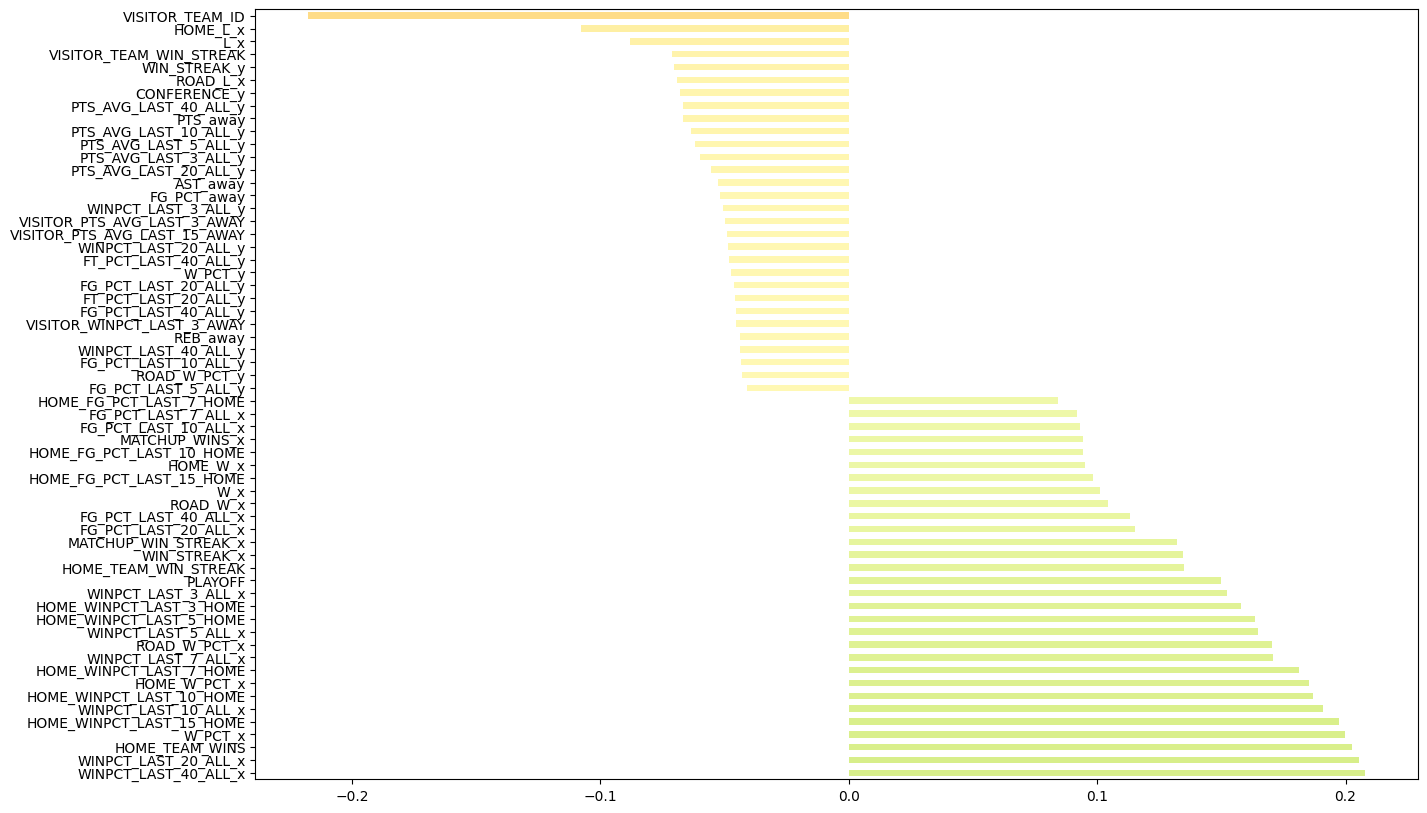

In [17]:
# correlations vs target

target = 'TARGET'
n = 30
drop_cols = ['GAME_ID','TARGET']

plot_corr_vs_target(train_features, target, drop_cols, n)

In [18]:
# run sweetviz report

run_sweetviz_report(train_features,'TARGET')

C:\Users\Chris\Desktop\DataScienceProjects\nba_game_predictor\venv\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
C:\Users\Chris\Desktop\DataScienceProjects\nba_game_predictor\venv\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()


                                             |          | [  0%]   00:00 -> (? left)

C:\Users\Chris\Desktop\DataScienceProjects\nba_game_predictor\venv\lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
C:\Users\Chris\Desktop\DataScienceProjects\nba_game_predictor\venv\lib\site-packages\sweetviz\series_analyzer_text.py:19: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in to_process.source_counts["value_counts_without_nan"].iteritems():
C:\Users\Chris\Desktop\DataScienceProjects\nba_game_predictor\venv\lib\site-packages\sweetviz\series_analyzer_numeric.py:25: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats["mad"] = series.mad()
C:\Users\Chris\Desktop\DataScienceProjects\nba_game_predictor\venv\lib\site-packages\sweetviz\series_analyzer_numeric.py

Report SWEETVIZ_2022-10-30_13_44.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Changelog / Notes

**2022-10-30**

Added "_by_season" to old versions of following functions and made new versions of each.

 - add_matchups
 - add_past_performance_home_away
 - add_past_performance_all
 
 New versions:
 
 - no longer grouped by season (rolling averages can extend back to previous season)
 - added longer term rolling/expanding averages
 


